In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pycolmap
import matplotlib.pyplot as plt

from hloc.visualization import plot_images
from megadepth.utils.io import load_depth_map, load_image

In [32]:
data = Path("/Volumes/Extreme_SSD/MegaDepth/scenes/")

scene = "5018"

model_name = "disk_lg+sift+splg"

img_dir = data / scene / "images"
undistorted_img_dir = data / scene / "dense" / model_name / "images"

depth_dir = data / scene / "dense" / model_name / "stereo" / "depth_maps"

model_path = data / scene / "dense" / model_name / "sparse"

model = pycolmap.Reconstruction(model_path)
print(model.summary())

Reconstruction:
	num_reg_images = 79
	num_cameras = 2
	num_points3D = 85066
	num_observations = 519844
	mean_track_length = 6.11107
	mean_observations_per_image = 6580.3
	mean_reprojection_error = 0.966188


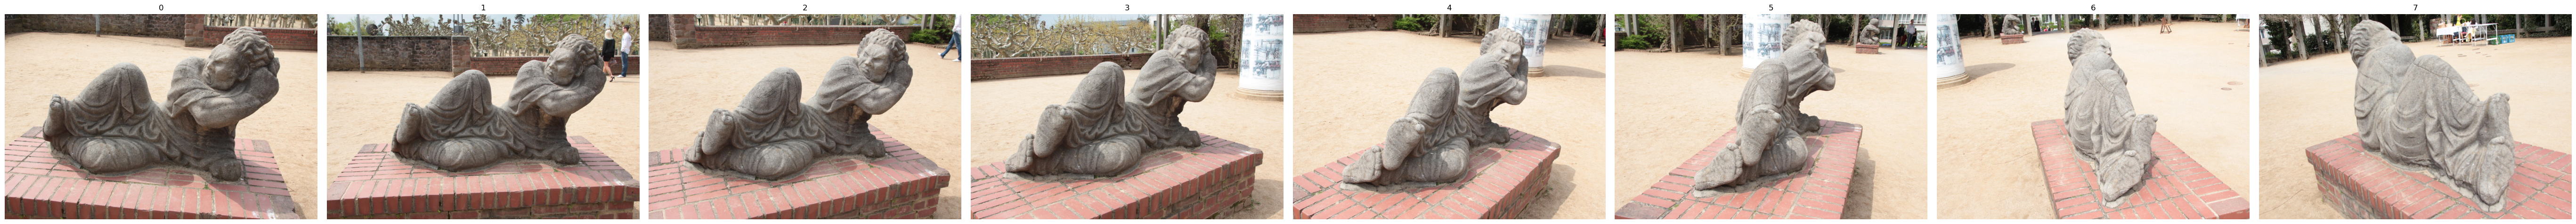

In [33]:
image_names = [im.name for im in model.images.values()]

N = 8

plot_images([load_image(undistorted_img_dir / im) for im in image_names[:N]], titles=range(N))

In [34]:
id_1 = 0
id_2 = 3

img1_name = image_names[id_1]
img2_name = image_names[id_2]

77 74


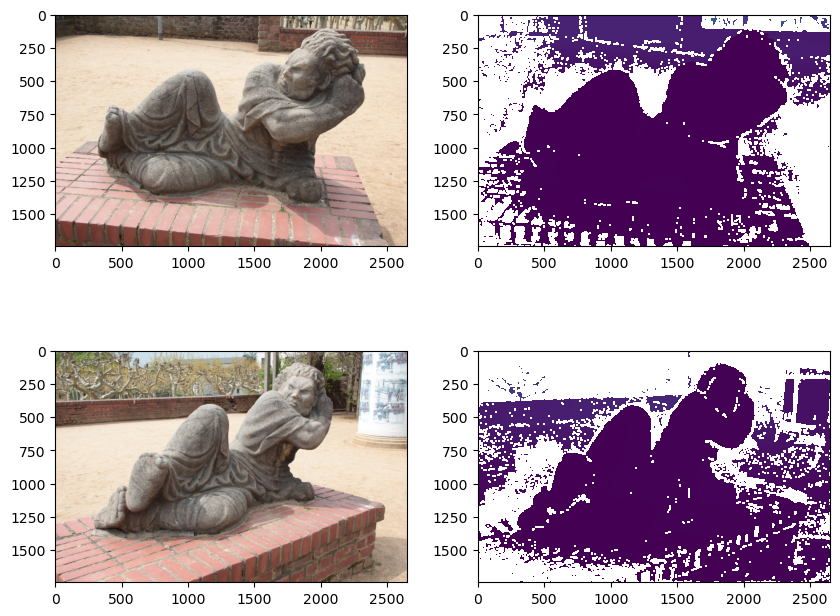

In [35]:
img1 = model.find_image_with_name(img1_name)
img2 = model.find_image_with_name(img2_name)

print(img1.image_id, img2.image_id)

cam1 = model.cameras[img1.camera_id]
cam2 = model.cameras[img2.camera_id]

depth1 = load_depth_map(depth_dir / f"{img1_name}.geometric.bin")
depth2 = load_depth_map(depth_dir / f"{img2_name}.geometric.bin")

depth1[depth1 <= 0] = np.nan
depth2[depth2 <= 0] = np.nan

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].imshow(load_image(undistorted_img_dir / img1_name))
ax[1, 0].imshow(load_image(undistorted_img_dir / img2_name))

ax[0, 1].imshow(depth1)
ax[1, 1].imshow(depth2)

plt.show()

# Project one image into another image

In [36]:
def get_grid_points(depth):
    return np.column_stack(np.where(~np.isnan(depth)))

In [37]:
def img2world(img, cam, depth, colors):
    p2d = get_grid_points(depth)
    colors = colors[p2d[:, 0], p2d[:, 1]]
    depth = depth[p2d[:, 0], p2d[:, 1]]

    p3d = np.array(cam.image_to_world(p2d))
    p3d = np.stack([p3d[:, 0], p3d[:, 1], np.ones_like(p3d[:, 0])]) * depth
    p3d = np.array(img.transform_to_world(p3d.T))

    return p3d, colors

In [38]:
def world2img(p3d, img, cam):

    p2d = np.array(np.round(cam.world_to_image(img.project(p3d))), dtype=int)
    depth = np.array(img.transform_to_image(p3d))[:, 2]

    xmin, xmax = 0, cam.height
    ymin, ymax = 0, cam.width
    mask = (
        (p2d[:, 0] >= xmin)
        & (p2d[:, 0] < xmax)
        & (p2d[:, 1] >= ymin)
        & (p2d[:, 1] < ymax)
    )

    return p2d, mask, depth

In [40]:
def img2world2img(img1, img2, cam1, cam2, depth1, colors1):
    """Projects image 1 to world space, then projects world space to image 2."""    
    p3d, colors = img2world(img1, cam1, depth1, colors1)
    p2d, mask, depth = world2img(p3d, img2, cam2)

    p2d = p2d[mask]
    colors = colors[mask]
    depth = depth[mask]

    return p2d, depth, colors

In [ ]:
def overlay(img1, img2, alpha=0.1):
    """Overlay two images."""
    return ((1 - alpha) * img1 + alpha * img2).astype(np.uint8)

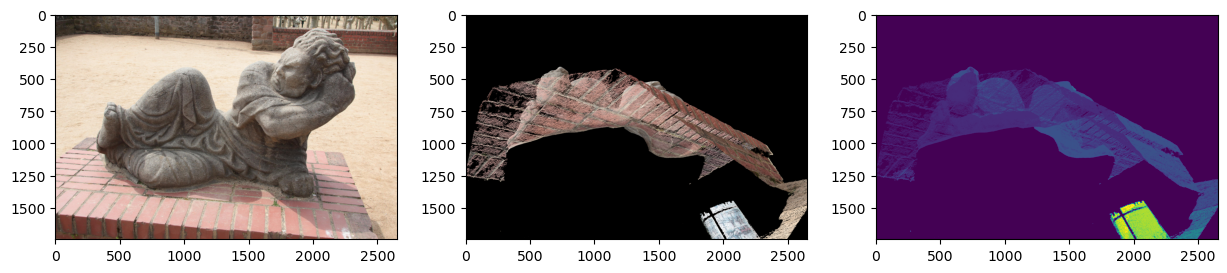

In [41]:
colors1 = load_image(undistorted_img_dir / img1.name)
colors2 = load_image(undistorted_img_dir / img2.name)

proj, depth, col = img2world2img(
    img1=img2,
    img2=img1,
    cam1=cam2,
    cam2=cam1,
    depth1=depth2,
    colors1=colors2,
)
img_proj = np.zeros_like(colors1)
img_proj[proj[:, 0], proj[:, 1]] = col

depth_proj = np.zeros_like(colors1)[:, :, 0]
depth_proj[proj[:, 0], proj[:, 1]] = depth

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(colors1)
ax[1].imshow(img_proj)
ax[2].imshow(depth_proj)

plt.show()

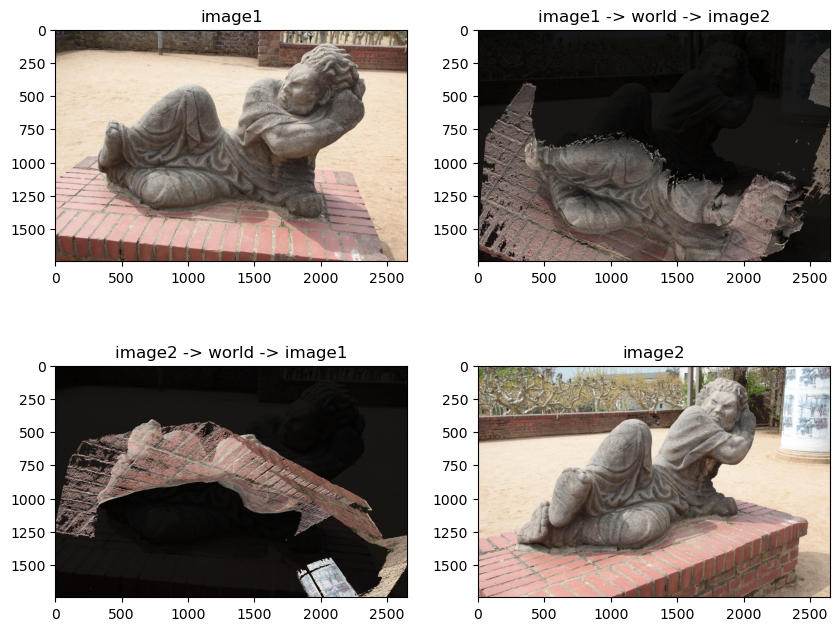

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
colors1 = load_image(undistorted_img_dir / img1.name)
colors2 = load_image(undistorted_img_dir / img2.name)

proj1to2, depth1to2, col1to2 = img2world2img(
    img1=img1,
    img2=img2,
    cam1=cam1,
    cam2=cam2,
    depth1=depth1,
    colors1=colors1,
)

img_proj1 = np.zeros_like(colors2)
img_proj1[proj1to2[:, 0], proj1to2[:, 1]] = col1to2

ax[0, 0].imshow(colors1)
ax[0, 0].set_title("image1")

ax[0, 1].imshow(overlay(img_proj1, colors2))
ax[0, 1].set_title("image1 -> world -> image2")


proj2to1, depth2to1, col2to1 = img2world2img(
    img1=img2,
    img2=img1,
    cam1=cam2,
    cam2=cam1,
    depth1=depth2,
    colors1=colors2,
)

img_proj2 = np.zeros_like(colors1)
img_proj2[proj2to1[:, 0], proj2to1[:, 1]] = col2to1

ax[1, 1].imshow(colors2)
ax[1, 1].set_title("image2")
ax[1, 0].imshow(overlay(img_proj2, colors1))
ax[1, 0].set_title("image2 -> world -> image1")

plt.show()